In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='3'
import tensorflow as tf
from tensorflow.keras import layers

## Data import

In [187]:
data_import = pd.read_csv('../Data/SQLout_employees.csv')

In [188]:
def observations_between_thresholds(df, lower_threshold=0.05, upper_threshold=0.95):
    """Select observations, with hourly rate between
     thresholds for lpk groups. Thresholds are defined by quantiles"""
    df['rank'] = df.groupby('lpk')['hourly_rate'].rank(pct=True).copy()
    df = df.query('rank < @upper_threshold & rank > @lower_threshold')
    df = df.drop(columns='rank')     
    return df

In [189]:
data2018ft = data_import.query('arrangement == "FT" & year==2018', inplace=False )[['nace', 
                          'esize_class', 'gender', 
                          'age_class', 'lpk',  'education','experience', 'hourly_rate']]

data2018ft.shape

(36785, 8)

In [190]:

upper_threshold = 0.90
lower_threshold = 0.05

data=data2018ft.copy()
data = observations_between_thresholds(data, lower_threshold=lower_threshold, upper_threshold=upper_threshold)
data = data.rename(columns={'hourly_rate': 'target'})
data = data.groupby('lpk').filter(lambda x: len(x) > 50)
data['lpk'] = data['lpk'].apply(str)
data.shape

(30782, 8)

In [191]:
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
44953,C,1_49,M,40-49,721,G2,13,8.20
44955,C,1_49,F,40-49,334,G2,0,2.51
44961,M,50_249,F,40-49,522,G2,0,2.26
44965,M,50_249,F,30-39,522,G2,11,2.39
44966,K,50_249,F,30-39,121,G4,3,5.80


## Spliting of dataframes for training, validation and testing

In [192]:
train, val, test = np.split(data.sample(frac=1), [int(0.7*len(data)), int(0.8*len(data))])
print(train.shape, val.shape, test.shape)

(21547, 8) (3078, 8) (6157, 8)


## Preprocessing functions
Based on: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers#create_compile_and_train_the_model

In [193]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe
  #df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value.to_numpy()[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

### Normalization of numeric features

In [194]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

### Encoding of string features

In [195]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

## Preprocessing

In [196]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [197]:
all_inputs = []
encoded_features = []

In [198]:
# Numerical features.
for header in ['experience']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [199]:
categorical_cols = ['nace', 'esize_class', 'gender', 'age_class', 'education', 'lpk']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string')
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

# Model and predictions

In [200]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(48, activation="relu", name="first_dense", kernel_regularizer=tf.keras.regularizers.l2(0.01))(all_features)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [201]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=10*1000,
  decay_rate=1,
  staircase=False)

In [202]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

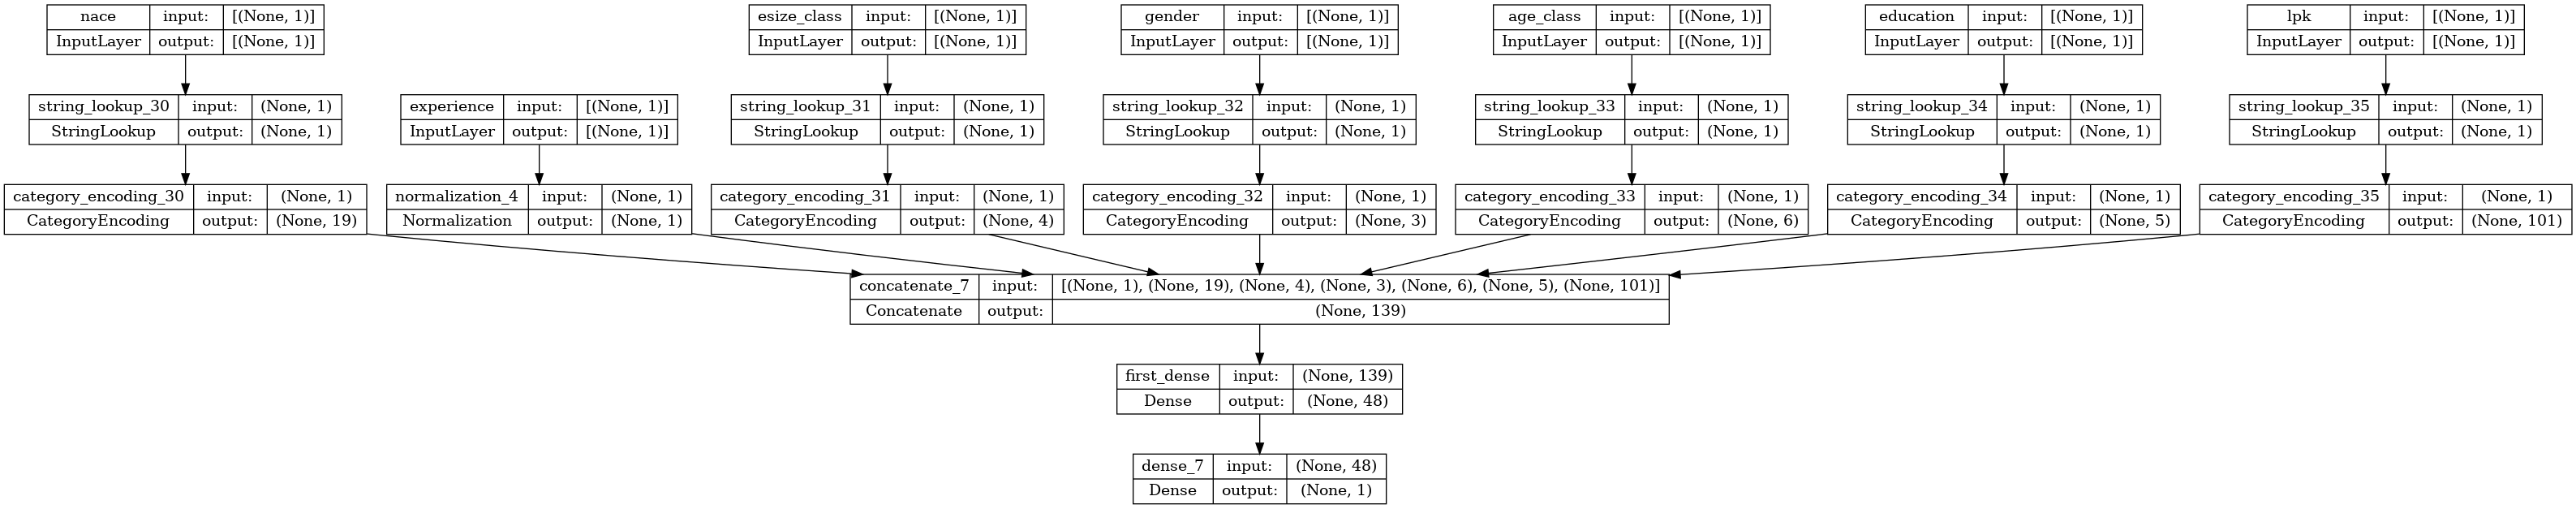

In [203]:
tf.keras.utils.plot_model(model, rankdir="TB", show_shapes=True)

In [204]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=10, 
    restore_best_weights=True,
)

In [205]:
history = model.fit(train_ds,
    validation_data=val_ds,
    epochs=300,
    callbacks=[early_stopping],
    verbose=0)

Minimum validation RMSE: 1.6841747760772705


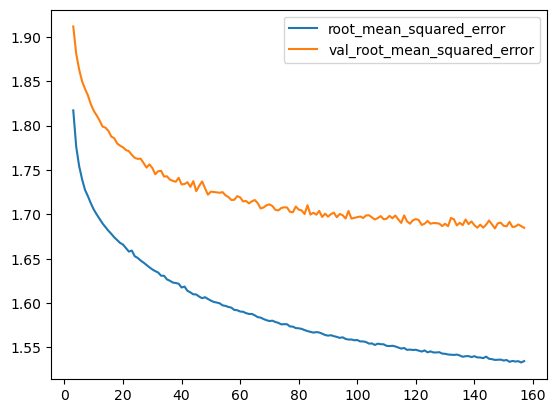

In [206]:
history_df = pd.DataFrame(history.history)
history_df.loc[3:, ['root_mean_squared_error', 'val_root_mean_squared_error']].plot();
print("Minimum validation RMSE: {}".format(history_df['val_root_mean_squared_error'].min()))

In [213]:
loss, rmse = model.evaluate(test_ds)

25/25 [==============================] - 0s 1ms/step - loss: 2.6770 - root_mean_squared_error: 1.5884


In [214]:
weights = model.get_layer("first_dense").weights

In [215]:
weights[0]

<tf.Variable 'first_dense/kernel:0' shape=(139, 48) dtype=float32, numpy=
array([[ 9.3172960e-02,  9.6995100e-02, -1.4875405e-03, ...,
         4.4386843e-03,  1.5465135e-02,  9.0434048e-03],
       [-2.5137008e-34, -2.1237661e-34,  3.4138863e-34, ...,
        -8.6362169e-35,  4.1375909e-35,  3.4801417e-34],
       [-6.9767376e-03,  2.6872724e-02, -1.8813411e-02, ...,
        -2.2226214e-02,  4.9629197e-02, -3.9685275e-02],
       ...,
       [ 1.3185024e-02,  2.3271870e-03, -7.9360390e-03, ...,
        -1.0561225e-02, -2.5216583e-02, -1.4373570e-02],
       [ 2.4080830e-02,  9.1360416e-03, -8.9913988e-03, ...,
        -1.1660535e-02, -3.5542507e-02, -1.5595977e-02],
       [ 2.3075223e-02,  5.1585253e-04, -1.4261677e-02, ...,
        -1.8860254e-02, -3.2917734e-02, -2.5363771e-02]], dtype=float32)>

In [216]:
weights[0][138].numpy()

array([ 2.30752230e-02,  5.15852531e-04, -1.42616769e-02, -1.34157259e-02,
       -1.26994355e-02, -1.35408891e-02,  3.59739922e-02, -2.09913999e-02,
       -2.45573223e-02, -1.29038068e-02, -2.19966248e-02,  1.96815971e-02,
       -1.96938124e-02,  2.49736123e-02, -1.98612381e-02, -9.46404180e-06,
       -7.90392831e-02, -1.81937311e-02, -2.34184051e-34,  2.84418669e-02,
        5.50762266e-02,  4.29969607e-03, -2.05625966e-02,  2.84474203e-03,
       -1.87386554e-02, -2.85842326e-02, -1.12161739e-02, -1.53542347e-02,
       -1.18271420e-02, -1.84700595e-34, -1.02397986e-02, -2.61427667e-02,
       -1.90403275e-02, -2.98344865e-02, -1.93385649e-02, -9.23339650e-03,
        3.82514438e-03,  1.14156501e-02, -1.58746131e-02, -3.11294850e-02,
       -1.87301431e-02,  5.48552051e-02, -1.78285558e-02, -1.51806595e-02,
       -1.07047465e-02, -1.88602544e-02, -3.29177342e-02, -2.53637712e-02],
      dtype=float32)

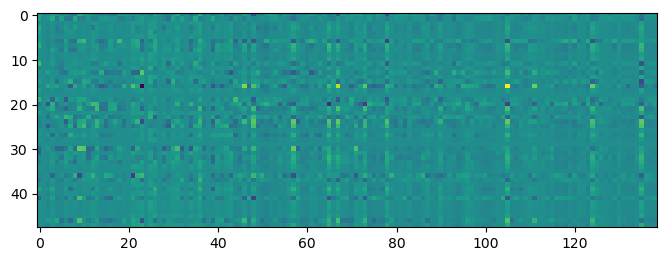

In [217]:
plt.figure(figsize=[8,4])
plt.imshow(weights[0].numpy().T);


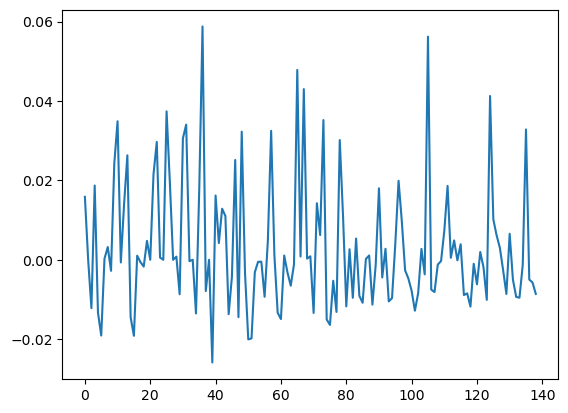

In [218]:
plt.plot(weights[0].numpy().T.mean(axis=0));